In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker


In [2]:
# load the data 
JOB_IDs = {"Opponent: strong, Iter=1, Gaussian/Orn": "1985807", 
           "Opponent: strong, Iter=8/4, Gauss/Orn": "1985808",
           "Opponent: weak, Iter=1, Gaussian": "1985908", # can also have 99.5% seldomly
           "Opponent: weak, Iter=1, Pink": "1986002", # slightly lower win rate (99.5%)
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck": "1986036"} # slightly lower win rate in eval
paths_map = {name: f"./{job_id}/logs/training_log.csv" for name, job_id in JOB_IDs.items()}


In [3]:
paths_map

{'Opponent: strong, Iter=1, Gaussian/Orn': './1985807/logs/training_log.csv',
 'Opponent: strong, Iter=8/4, Gauss/Orn': './1985808/logs/training_log.csv',
 'Opponent: weak, Iter=1, Gaussian': './1985908/logs/training_log.csv',
 'Opponent: weak, Iter=1, Pink': './1986002/logs/training_log.csv',
 'Opponent: weak, Iter=1, Ornstein-Uhlenbeck': './1986036/logs/training_log.csv'}

In [4]:
# STYLE SETUP
plt.rcParams.update({
    'figure.facecolor':     '#fafafa',
    'axes.facecolor':       '#fafafa',
    'axes.edgecolor':       '#cccccc',
    'axes.grid':            True,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.xmargin':         0.01,
    'axes.ymargin':         0.0,   
    'grid.alpha':           0.3,
    'grid.color':           '#888888',
    'grid.linestyle':       '--',
    'font.family':          'sans-serif',
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'axes.labelsize':       12,
    'legend.fontsize':      10,
    'legend.framealpha':    0.9,
    'legend.edgecolor':     '#cccccc',
    'figure.dpi':           130,
    'savefig.dpi':          200,
    'savefig.bbox':         'tight',
})

COLORS = ['#2176AE', '#E05A3A', 
          '#57A773', '#D4A843', 
          '#8B5FBF', '#E87EA1']

SMOOTHING_WINDOW = 100

def get_color(i):
    return COLORS[i % len(COLORS)]

In [5]:
# ** LOAD DATA **
runs = {}
for name, path in paths_map.items():
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    # derive smoothed values for calmer plots
    df['smoothed_episode_reward'] = df['episode_reward'].rolling(SMOOTHING_WINDOW,
                                                                 min_periods=1).mean()
    df['win']  = (df['winner'] == 1).astype(int)
    df['loss'] = (df['winner'] == -1).astype(int)
    df['tie']  = (df['winner'] == 0).astype(int)
    df['win_rate']  = df['win'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    df['loss_rate'] = df['loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    df['tie_rate']  = df['tie'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    
    runs[name] = df
    print(f"{name}: {len(df)} episodes, "
          f"{df['total_steps'].iloc[-1]} total steps, "
          )

Opponent: strong, Iter=1, Gaussian/Orn: 50000 episodes, 2370322 total steps, 
Opponent: strong, Iter=8/4, Gauss/Orn: 50000 episodes, 2762123 total steps, 
Opponent: weak, Iter=1, Gaussian: 50000 episodes, 3401496 total steps, 
Opponent: weak, Iter=1, Pink: 50000 episodes, 2866549 total steps, 
Opponent: weak, Iter=1, Ornstein-Uhlenbeck: 50000 episodes, 3240003 total steps, 


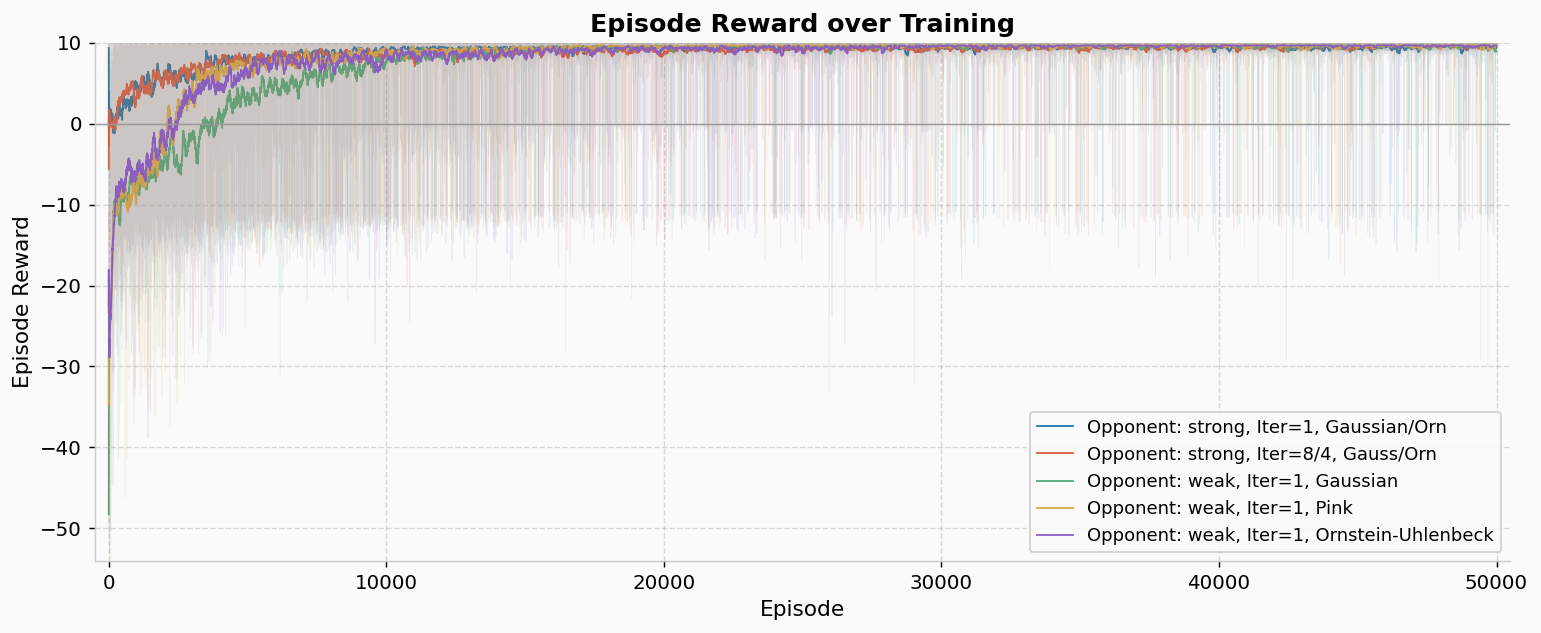

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    ax.plot(df['episode'], df['episode_reward'], 
            alpha=0.1, color=c, linewidth=0.5)
    ax.plot(df['episode'], df['smoothed_episode_reward'], 
            color=c, linewidth=1,
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Episode Reward over Training')
ax.legend()
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

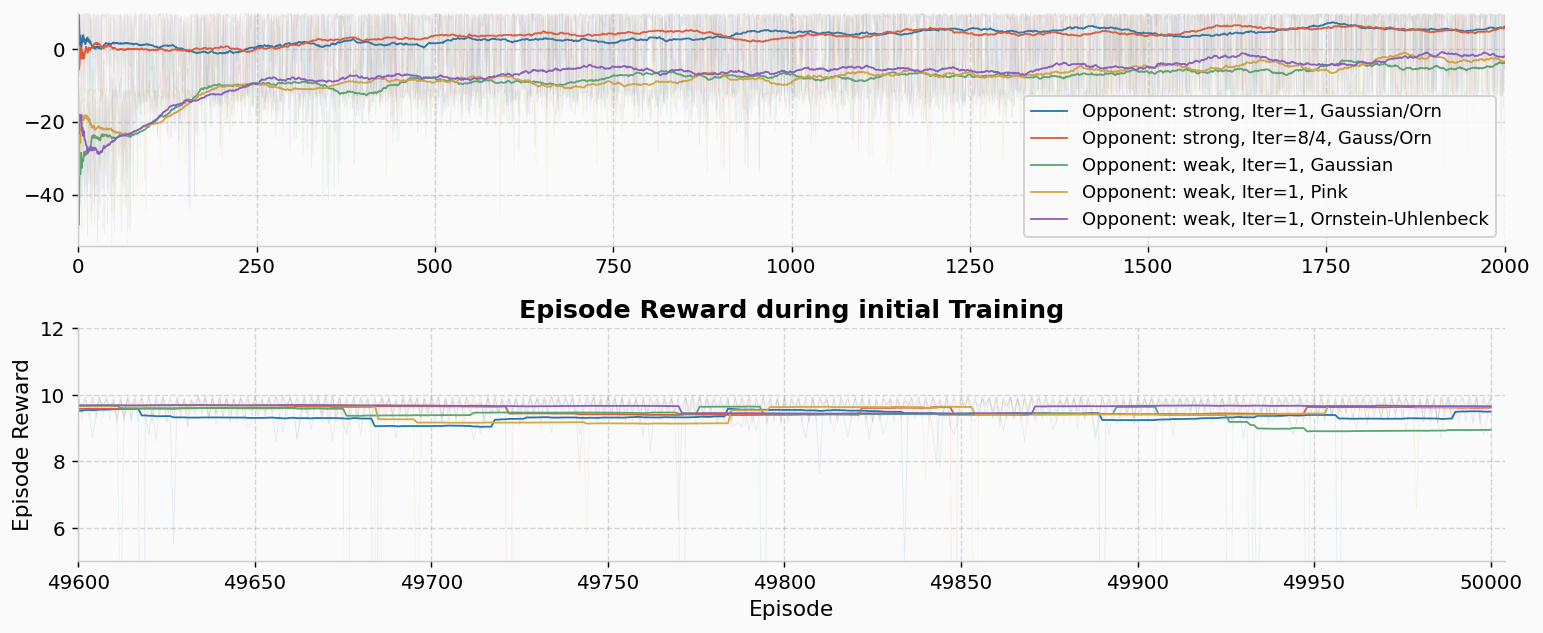

In [7]:
# close up
EPISODE_MAX = 2000
EPISODE_MIN = 49_600

windows = [
    ("Early training", lambda df: df[df["episode"] <= EPISODE_MAX], (0, EPISODE_MAX)),
    ("Late training",  lambda df: df[df["episode"] >= EPISODE_MIN], (EPISODE_MIN, None)),
]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))
for j, (title, filter, xlim) in enumerate(windows):
        for i, (name, df) in enumerate(runs.items()):
                ax = axes[j]
                c = get_color(i)
                d = filter(df)
                ax.plot(d['episode'], d['episode_reward'], 
                        alpha=0.1, color=c, linewidth=0.5)
                ax.plot(d['episode'], d['smoothed_episode_reward'], 
                        color=c, linewidth=1,
                        label=name)
        if xlim[1] is None:
                ax.set_xlim(left=xlim[0])
        else:
                ax.set_xlim(*xlim)
axes[-1].set_ylim(bottom=5, top=12)
axes[-1].set_xlabel("Episode")
axes[0].legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Episode Reward during initial Training')
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

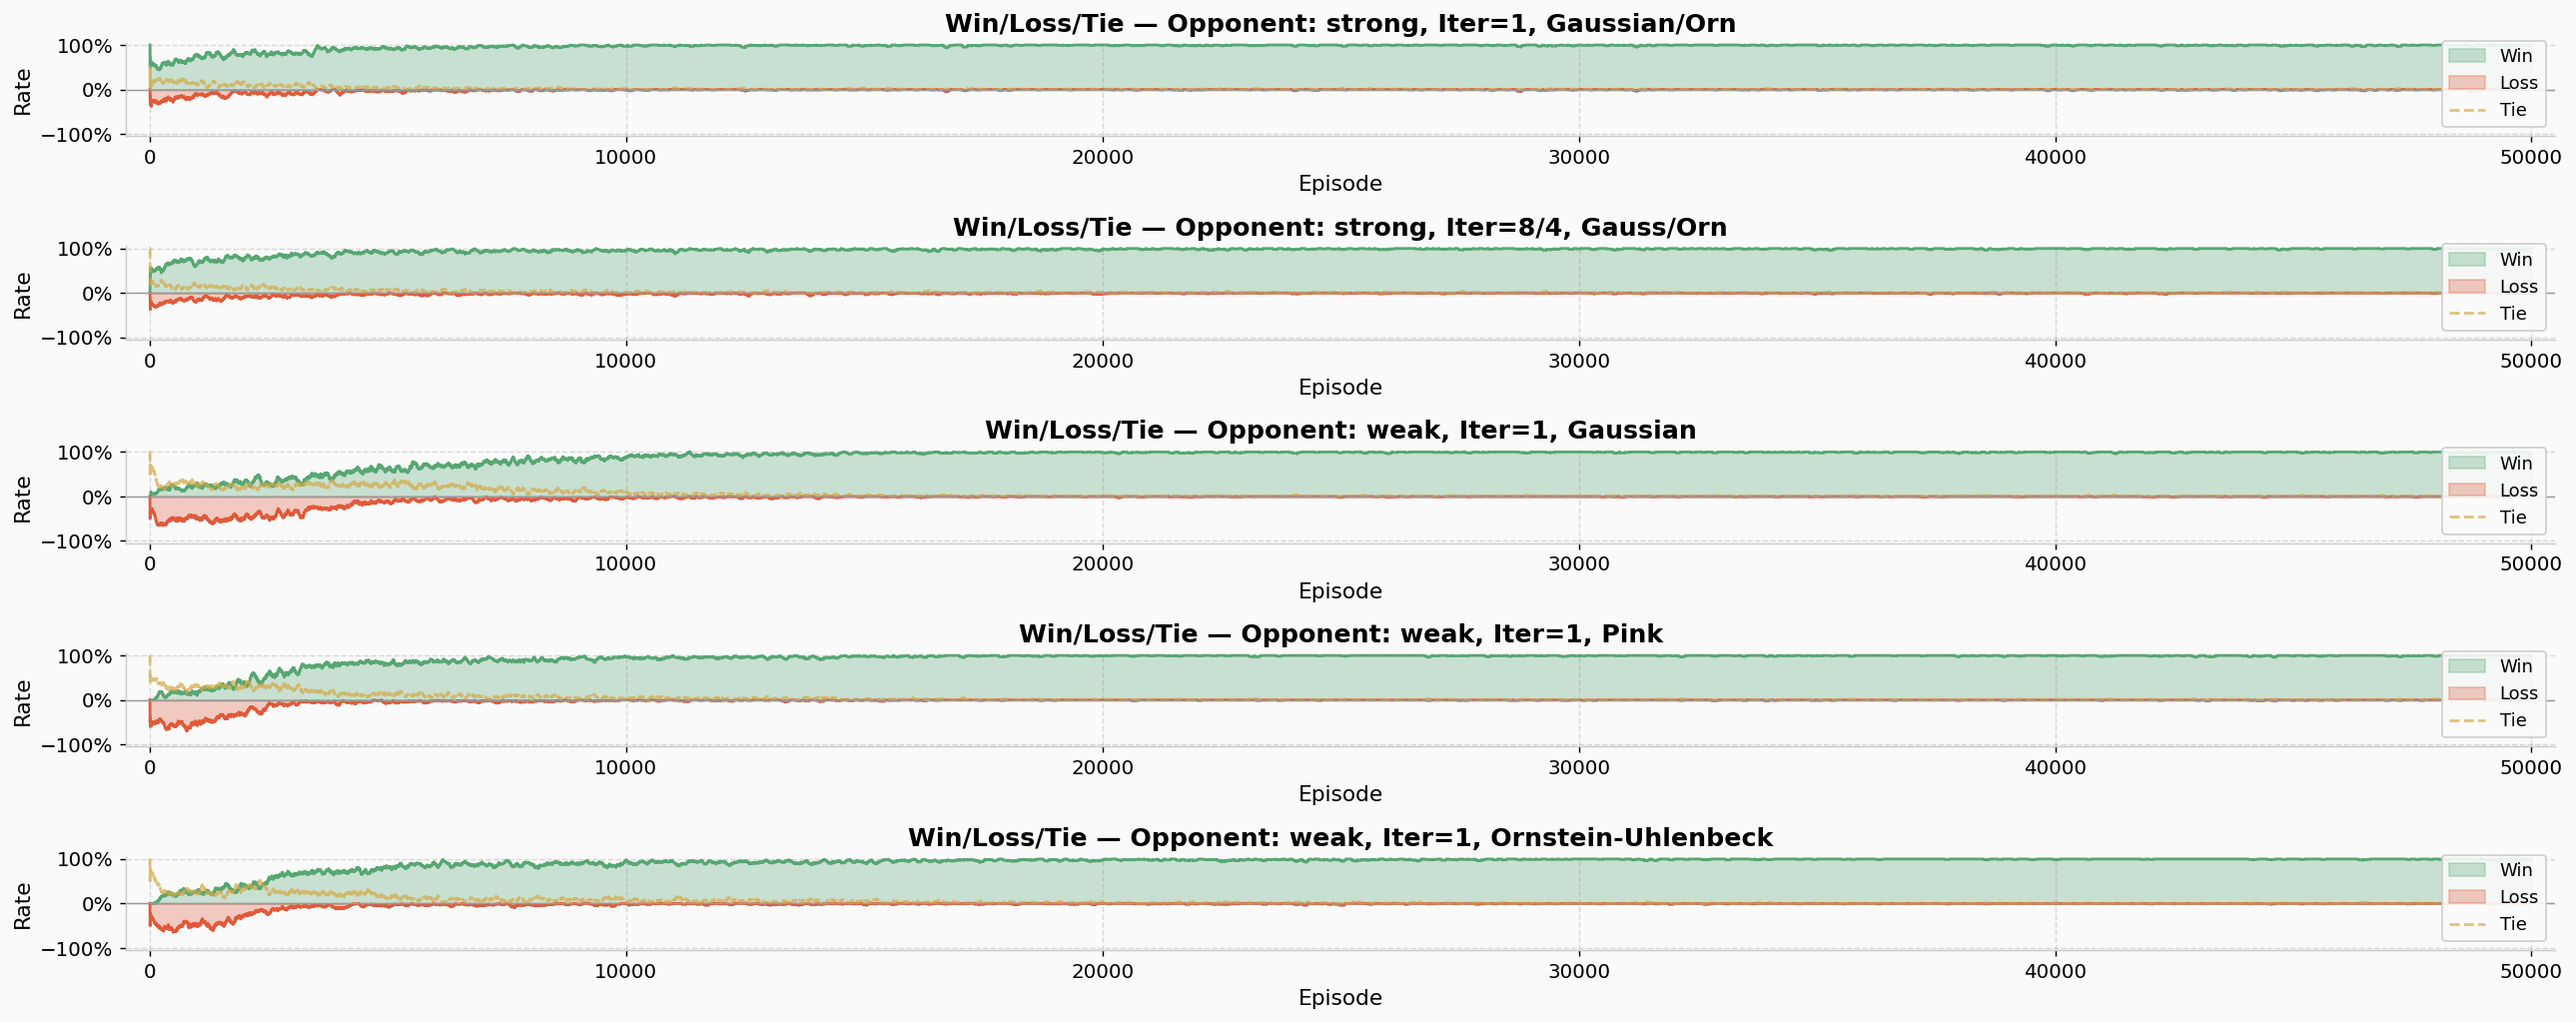

In [8]:
n_runs = len(runs)
fig, axes = plt.subplots(n_runs, 1, figsize=(4 * n_runs, 8), squeeze=False)

for i, (name, df) in enumerate(runs.items()):
    ax = axes[i, 0]
    ax.fill_between(df['episode'], 0, df['win_rate'],
                    alpha=0.3, color='#57A773', label='Win')
    ax.fill_between(df['episode'], 0, -df['loss_rate'],
                    alpha=0.3, color='#E05A3A', label='Loss')
    ax.plot(df['episode'], df['win_rate'],  color='#57A773', linewidth=1.5)
    ax.plot(df['episode'], -df['loss_rate'], color='#E05A3A', linewidth=1.5)
    ax.plot(df['episode'], df['tie_rate'],  color='#D4A843', linewidth=1.5,
            alpha=0.7, label='Tie', linestyle='--')
    ax.axhline(0, color='#999999', linewidth=0.8)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rate')
    ax.set_title(f'Win/Loss/Tie — {name}')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [9]:
# validate win rate every 100 episodes

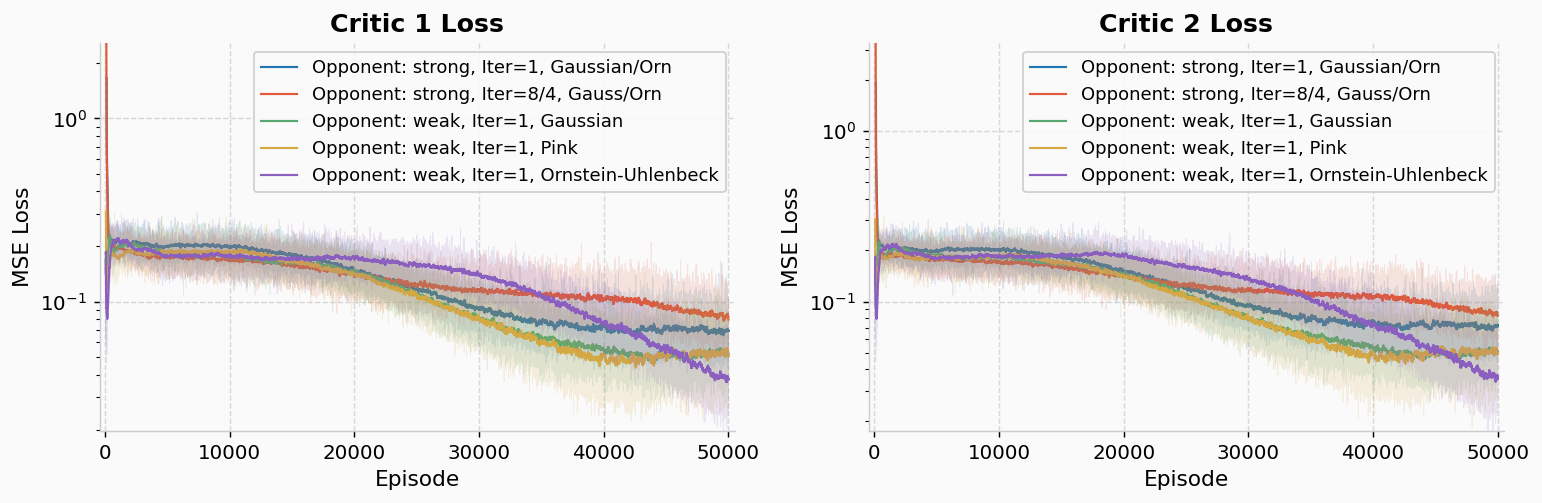

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    # Filter out zeros (episodes before warmup)
    mask = df['critic1_loss'] > 0
    ep = df.loc[mask, 'episode']

    for j, col in enumerate(['critic1_loss', 'critic2_loss']):
        ax = axes[j]
        raw = df.loc[mask, col]
        smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        ax.plot(ep, raw, alpha=0.15, color=c, linewidth=0.5)
        ax.plot(ep, smooth, color=c, linewidth=1.2, label=name)

for j, title in enumerate(['Critic 1 Loss', 'Critic 2 Loss']):
    axes[j].set_xlabel('Episode')
    axes[j].set_ylabel('MSE Loss')
    axes[j].set_title(title)
    axes[j].legend()
    axes[j].set_yscale('log')

plt.tight_layout()
plt.show()

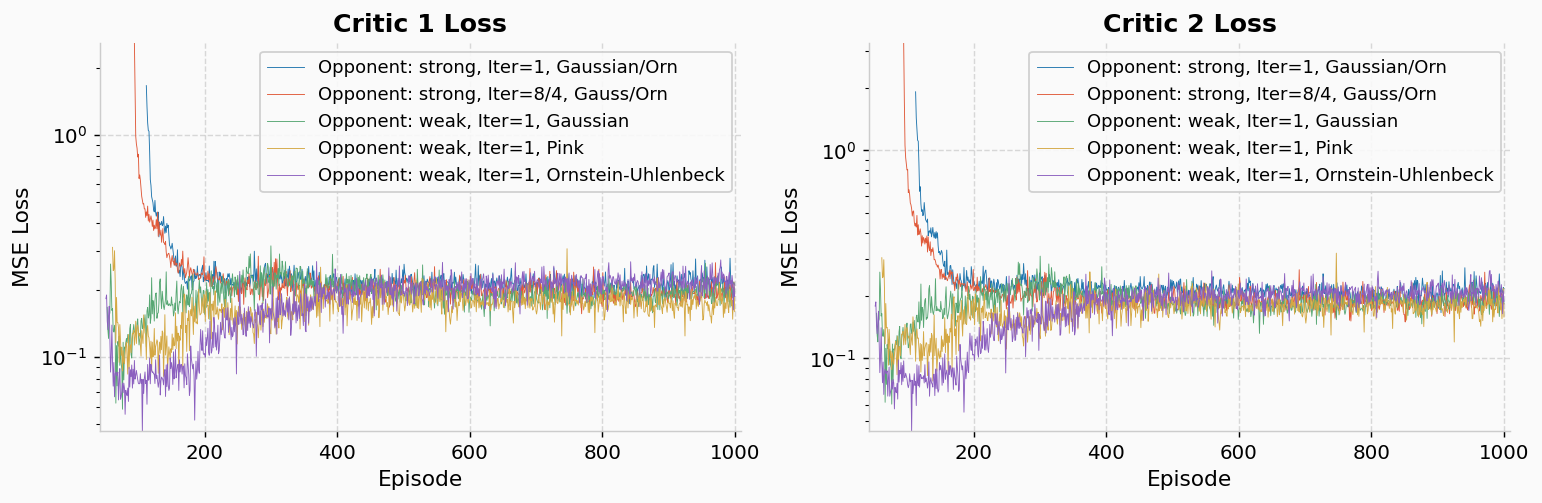

In [11]:
# zoom in to the beginning
EPISODE_MAX = 1000

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    d = df[df["episode"] <= EPISODE_MAX]

    # Filter out zeros (episodes before warmup)
    mask = d['critic1_loss'] > 0
    ep = d.loc[mask, 'episode']

    for j, col in enumerate(['critic1_loss', 'critic2_loss']):
        ax = axes[j]
        raw = d.loc[mask, col]
        smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        ax.plot(ep, raw, alpha=1, color=c, linewidth=0.5, label=name)
        #ax.plot(ep, smooth, color=c, linewidth=2, label=name)

for j, title in enumerate(['Critic 1 Loss', 'Critic 2 Loss']):
    axes[j].set_xlabel('Episode')
    axes[j].set_ylabel('MSE Loss')
    axes[j].set_title(title)
    axes[j].legend()
    axes[j].set_yscale('log')

plt.tight_layout()
plt.show()

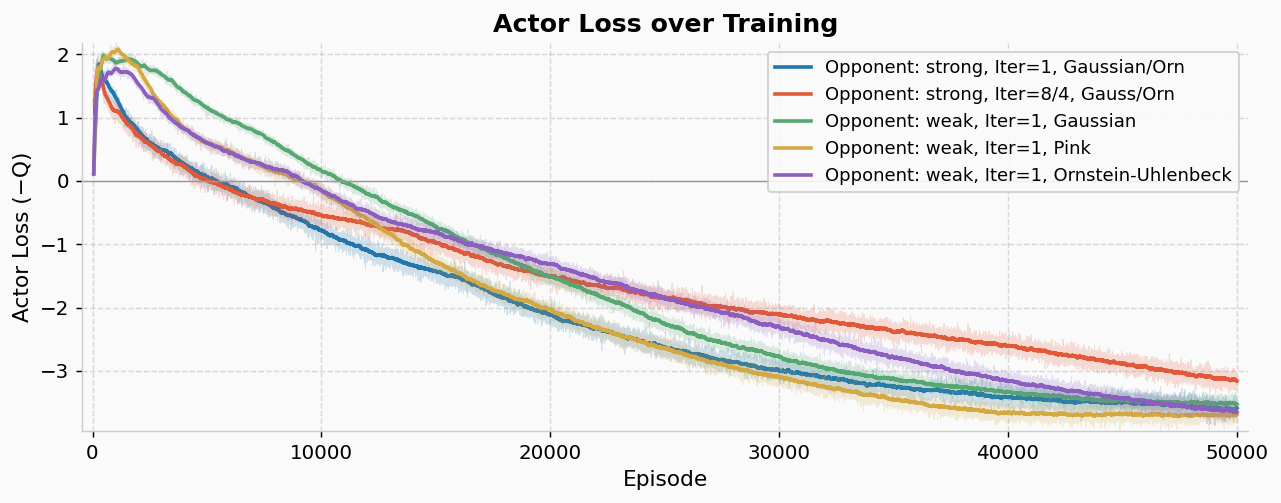

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    mask = df['actor_loss'] != 0
    ep = df.loc[mask, 'episode']
    raw = df.loc[mask, 'actor_loss']
    smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, raw, alpha=0.2, color=c, linewidth=0.5)
    ax.plot(ep, smooth, color=c, linewidth=2, label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Actor Loss (−Q)')
ax.set_title('Actor Loss over Training')
ax.legend()
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

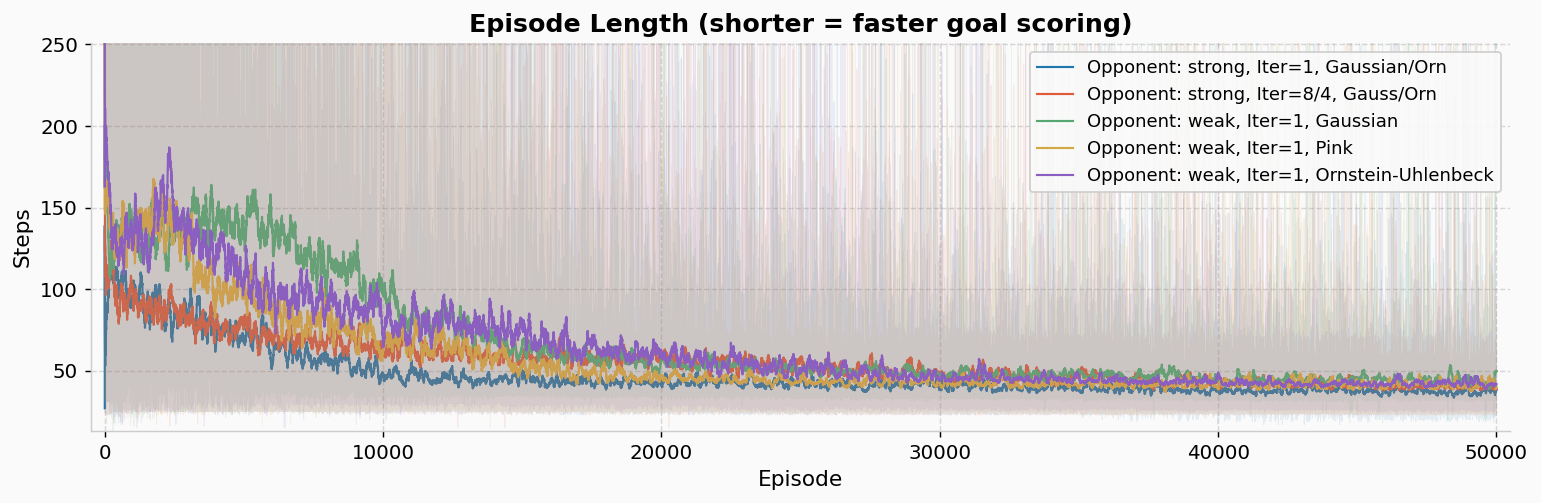

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    smooth = df['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(df['episode'], df['episode_length'], alpha=0.1, color=c, linewidth=0.5)
    ax.plot(df['episode'], smooth, color=c, linewidth=1.2, label=name)
#ax.axhline(250, color='#999999', linewidth=1, linestyle=':', label='Max (250)')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps')
ax.set_title('Episode Length (shorter = faster goal scoring)')
ax.legend()
plt.tight_layout()
plt.show()

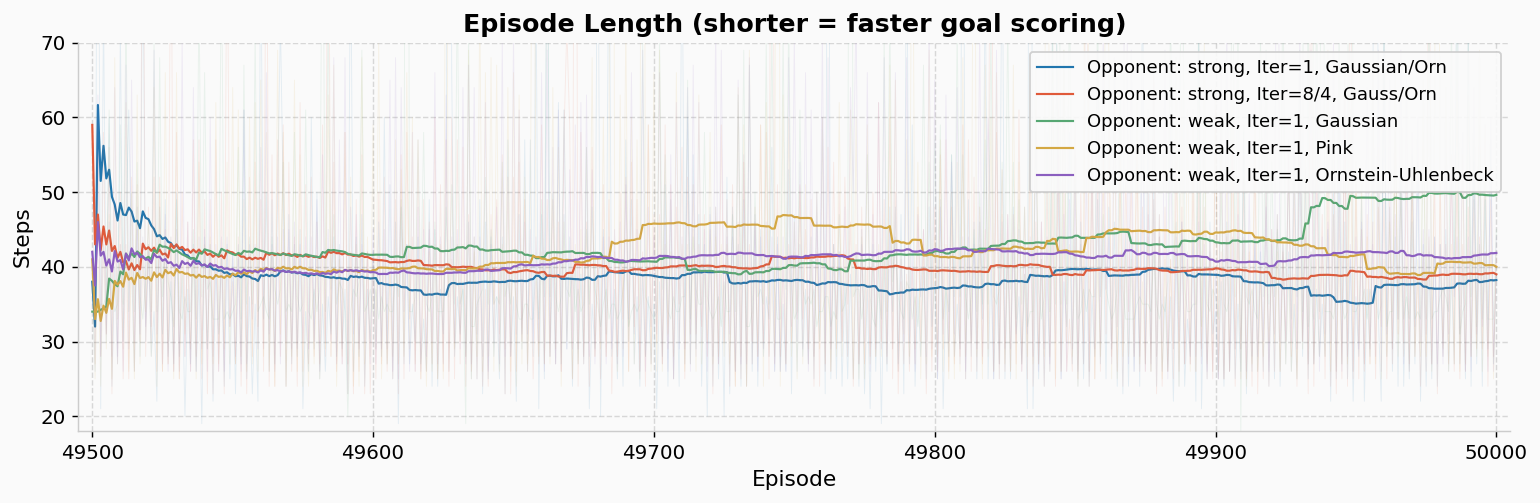

In [14]:
# zoom into the end
EPISODE_MIN = 49_500

fig, ax = plt.subplots(figsize=(12, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    d = df[df["episode"] >= EPISODE_MIN]
    smooth = d['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(d['episode'], d['episode_length'], alpha=0.1, color=c, linewidth=0.5)
    ax.plot(d['episode'], smooth, color=c, linewidth=1.2, label=name)
#ax.axhline(250, color='#999999', linewidth=1, linestyle=':', label='Max (250)')
ax.set_xlabel('Episode')
ax.set_ylim(top=70)
ax.set_ylabel('Steps')
ax.set_title('Episode Length (shorter = faster goal scoring)')
ax.legend()
plt.tight_layout()
plt.show()

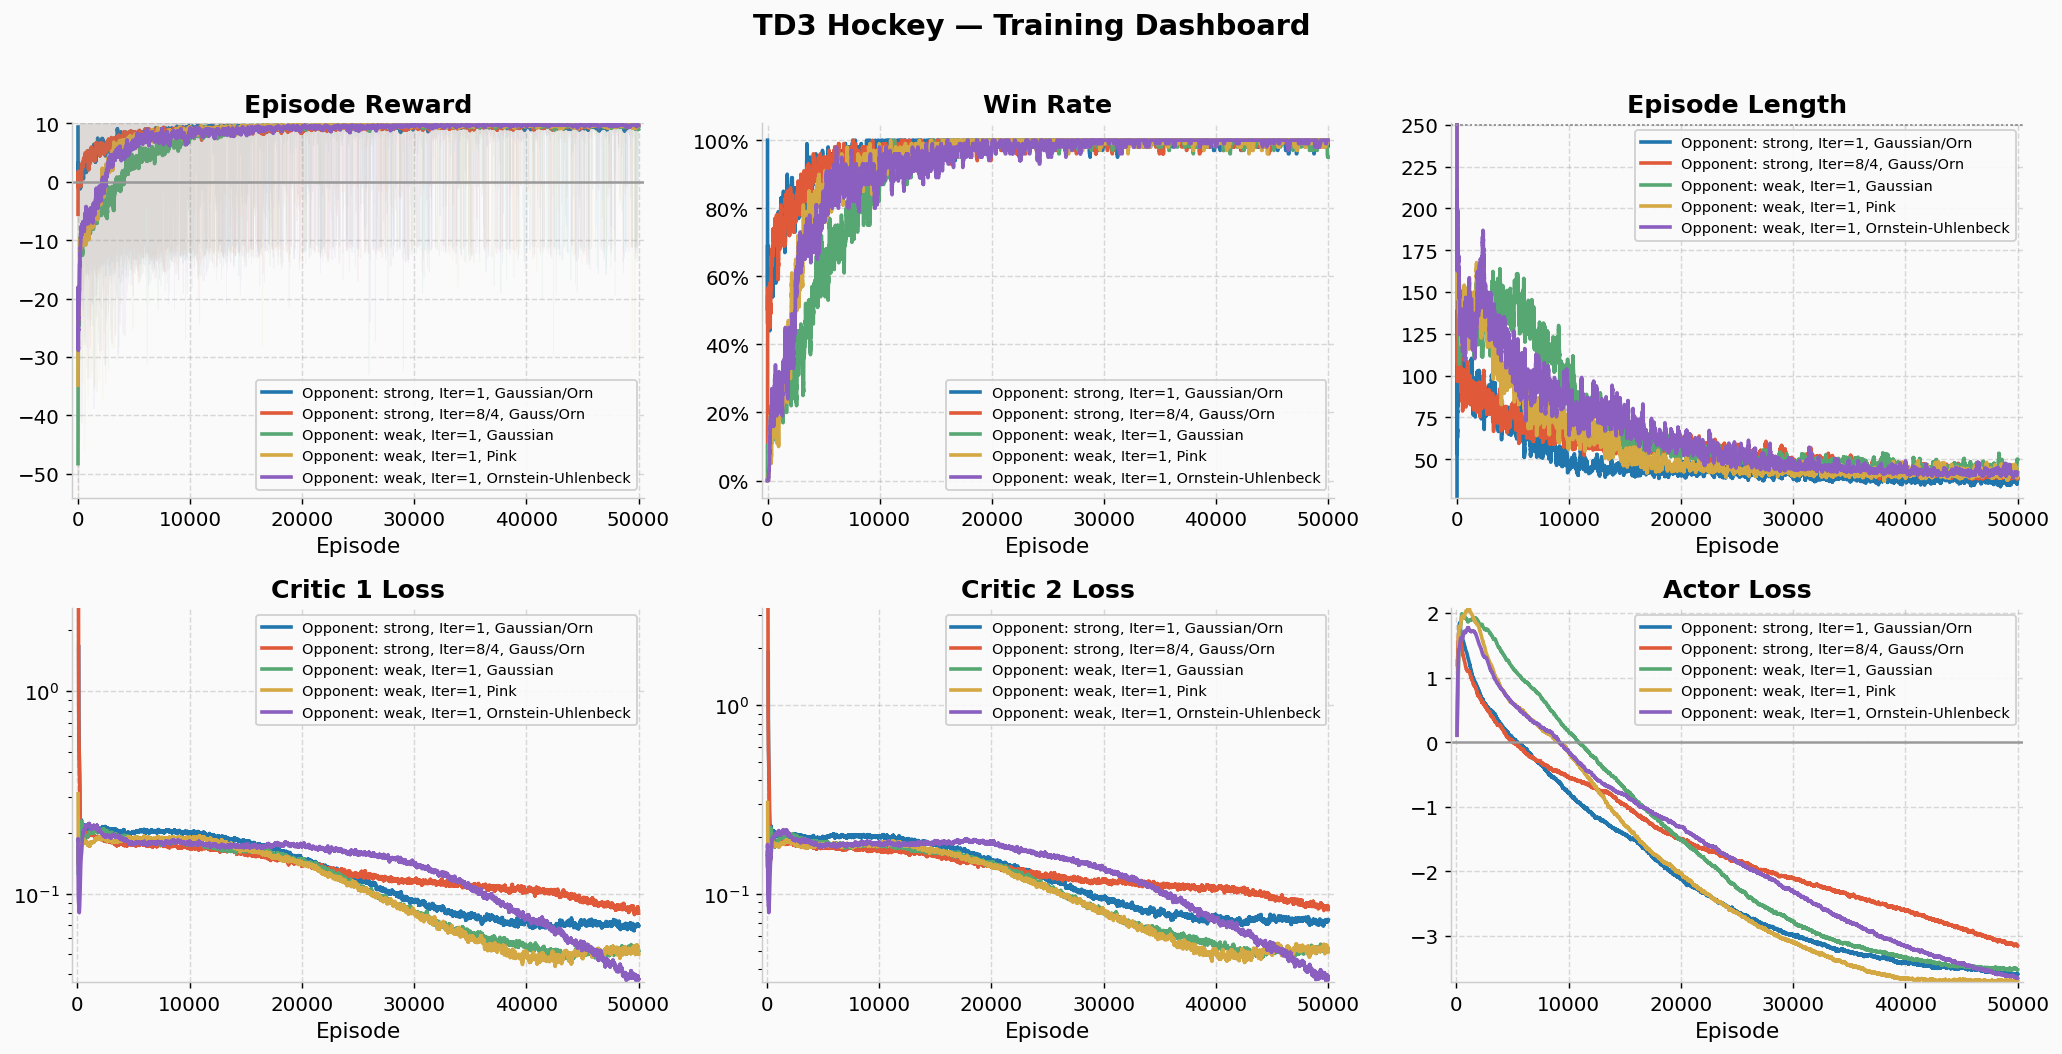

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('TD3 Hockey — Training Dashboard', fontsize=16, fontweight='bold', y=1.01)

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    mask_loss = df['critic1_loss'] > 0
    mask_actor = df['actor_loss'] != 0

    # (0,0) Reward
    ax = axes[0, 0]
    ax.plot(df['episode'], df['episode_reward'], alpha=0.06, color=c, linewidth=0.5)
    ax.plot(df['episode'], df['smoothed_episode_reward'], color=c, linewidth=2, label=name)
    ax.set_title('Episode Reward')
    ax.axhline(0, color='#999999', linewidth=0.8)

    # (0,1) Win rate
    ax = axes[0, 1]
    ax.plot(df['episode'], df['win_rate'], color=c, linewidth=2, label=name)
    ax.set_title('Win Rate')
    ax.set_ylim(-0.05, 1.05)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

    # (0,2) Episode length
    ax = axes[0, 2]
    smooth_len = df['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(df['episode'], smooth_len, color=c, linewidth=2, label=name)
    ax.axhline(250, color='#999999', linewidth=1, linestyle=':')
    ax.set_title('Episode Length')

    # (1,0) Critic 1
    ax = axes[1, 0]
    ep = df.loc[mask_loss, 'episode']
    smooth_c1 = df.loc[mask_loss, 'critic1_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, smooth_c1, color=c, linewidth=2, label=name)
    ax.set_title('Critic 1 Loss')
    ax.set_yscale('log')

    # (1,1) Critic 2
    ax = axes[1, 1]
    smooth_c2 = df.loc[mask_loss, 'critic2_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, smooth_c2, color=c, linewidth=2, label=name)
    ax.set_title('Critic 2 Loss')
    ax.set_yscale('log')

    # (1,2) Actor loss
    ax = axes[1, 2]
    ep_a = df.loc[mask_actor, 'episode']
    smooth_a = df.loc[mask_actor, 'actor_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep_a, smooth_a, color=c, linewidth=2, label=name)
    ax.set_title('Actor Loss')
    ax.axhline(0, color='#999999', linewidth=0.8)

for ax in axes.flat:
    ax.set_xlabel('Episode')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

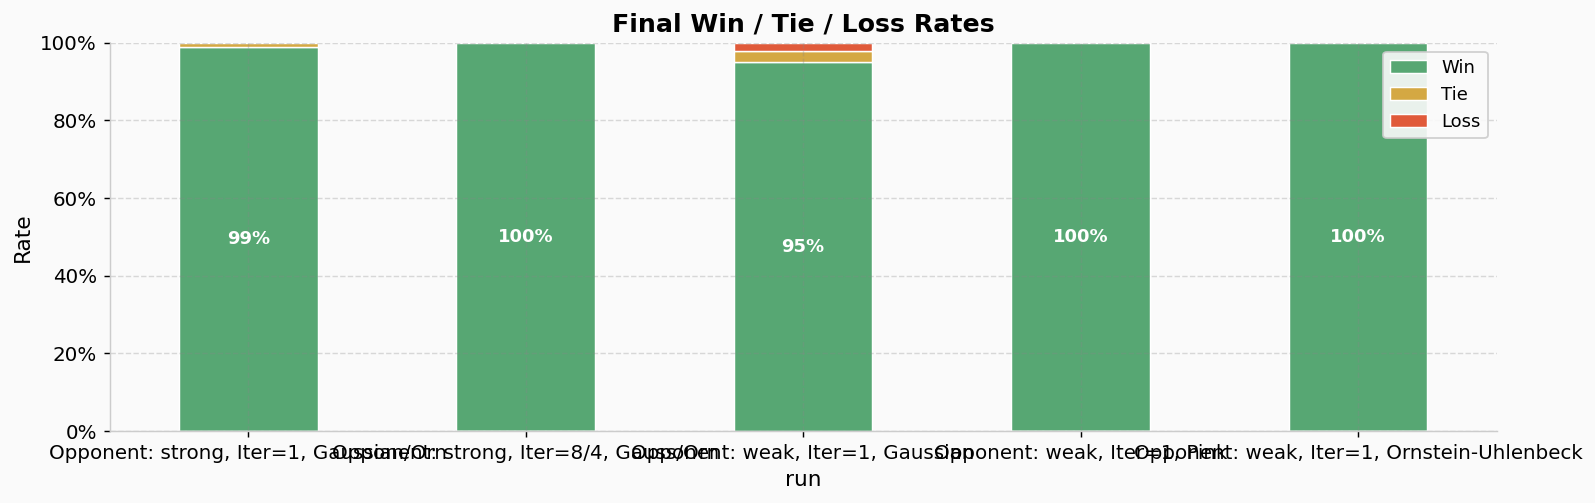

In [16]:
# Compute final rates (last SMOOTHING_WINDOW episodes)
summary = []
for name, df in runs.items():
    tail = df.tail(SMOOTHING_WINDOW)
    summary.append({
        'run': name,
        'Win':  tail['win'].mean(),
        'Tie':  tail['tie'].mean(),
        'Loss': tail['loss'].mean(),
    })
summary_df = pd.DataFrame(summary).set_index('run')

fig, ax = plt.subplots(figsize=(max(4, 2.5 * len(runs)), 4))
bar_colors = ['#57A773', '#D4A843', '#E05A3A']
summary_df.plot.bar(stacked=True, color=bar_colors, edgecolor='white',
                    linewidth=0.8, ax=ax, width=0.5)
ax.set_ylabel('Rate')
ax.set_title('Final Win / Tie / Loss Rates')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax.legend(loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate percentages
for i, (_, row) in enumerate(summary_df.iterrows()):
    cumulative = 0
    for col, color in zip(['Win', 'Tie', 'Loss'], bar_colors):
        val = row[col]
        if val > 0.03:  # only label if big enough to read
            ax.text(i, cumulative + val / 2, f'{val:.0%}',
                    ha='center', va='center', fontsize=10, fontweight='bold',
                    color='white')
        cumulative += val

plt.tight_layout()
plt.show()

# State visitation

In [17]:
import hockey.hockey_env as hockey_env
from TD3_agent import TD3_Agent
from gymnasium import spaces

env = hockey_env.HockeyEnv()
full_action_space = env.action_space
n_actions_per_player = full_action_space.shape[0] // 2
agent_action_space = spaces.Box(low=full_action_space.low[:n_actions_per_player],
                                high=full_action_space.high[:n_actions_per_player],
                                dtype=full_action_space.dtype)
device = "cpu"
TD3 = TD3_Agent(
    obs_dim = env.observation_space.shape[0],
    act_dim = n_actions_per_player,
    observation_space = env.observation_space,
    action_space = agent_action_space, 
    device = device,
)
TD3.load('./1985808/saved/td3_final.pt')
# collect states from a rollout
states = []
state, _ = env.reset()
for _ in range(10000):
    action = TD3.select_action(state, explore=True)
    state, _, terminated, truncated, _ = env.step(action)
    states.append(state)
    if terminated or truncated:
        state, _ = env.reset()

states = np.array(states)

# PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(states)

plt.scatter(proj[:, 0], proj[:, 1], alpha=0.1, s=1)
plt.title(f"State coverage (PCA) — explained variance: {pca.explained_variance_ratio_.sum():.1%}")

Loaded saved from ./1985808/saved/td3_final.pt


TypeError: Expected tuple or list of length 2, got length 0